In [1]:
import scanpy as sc
import anndata as ad
import squidpy as sq

import numpy as np
import pandas as pd

from csv import writer

In [2]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.1.0
PyQt5               NA
asciitree           NA
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
brotli              NA
cffi                1.15.0
click               8.1.3
cloudpickle         2.1.0
colorama            0.4.4
concurrent          NA
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.2
dask                2022.8.0
dask_image          2021.12.0
dateutil            2.8.2
decorator           5.1.1
defusedxml          0.7.1
distributed         2022.8.0
docrep              0.3.2
encodings           NA
entrypoints         0.4
executing           0.8.3
fasteners           0.17.3
fsspec              2022.7.1
genericpath         NA
h5py                3.6.0
heapdict            NA
hypergeom_ufunc     NA
igraph              0.9.1
imagecodecs         2022.2.22
imageio             2.21.1
ipykernel           5.5.5
ipython_genutils    0.2.0
ipywid

I use the mouse brain data set used in [this squidpy tutorial](https://squidpy.readthedocs.io/en/stable/auto_tutorials/tutorial_visium_hne.html#sphx-glr-auto-tutorials-tutorial-visium-hne-py).

I combine this with the [scanpy tutorial for visium data](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html)

In [3]:
# load the pre-processed dataset
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()

# Do that using it from a ramdisk for better processing
# Load on ramdisk with:
# 1. mount ramdisk
# 2. sudo cp Vic/development/data/Mouse_Brain_squidpy_tutorial.h5ad /mnt/ramdisk/
# 3. sudo cp Vic/development/data/V1_Adult_Mouse_Brain_image.tif /mnt/ramdisk

# img = sq.im.ImageContainer.load("/mnt/ramdisk/V1_Adult_Mouse_Brain_image.tif")
# adata = sc.read_h5ad("/mnt/ramdisk/Mouse_Brain_squidpy_tutorial.h5ad")

Adding image layer `image`


In [4]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

# normalize expression data
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [5]:
# skipping the QC and preprocessing step bc. I think this stuff should be filtered/preprocessed already

## Image features
Here, we will extract summary features at different crop sizes and scales to allow the calculation of multi-scale features and segmentation features.  (squidpy)

In [5]:
# calculate features for different scales (higher value means more context)
for scale in [1.0, 2.0]:
    feature_name = f"features_summary_scale{scale}"
    sq.im.calculate_image_features(
        adata,
        img.compute(),
        features="summary",
        key_added=feature_name,
        n_jobs=4,
        scale=scale,
    )


# combine features in one dataframe
adata.obsm["features"] = pd.concat(
    [adata.obsm[f] for f in adata.obsm.keys() if "features_summary" in f], axis="columns"
)
# make sure that we have no duplicated feature names in the combined table
adata.obsm["features"].columns = ad.utils.make_index_unique(adata.obsm["features"].columns)

  0%|          | 0/2688 [00:00<?, ?/s]

  0%|          | 0/2688 [00:00<?, ?/s]

We can use the extracted image features to compute a new cluster annotation. This could be useful to gain insights in similarities across spots based on image morphology.

/tmp/ipykernel_71194/636492175.py:12: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(features)


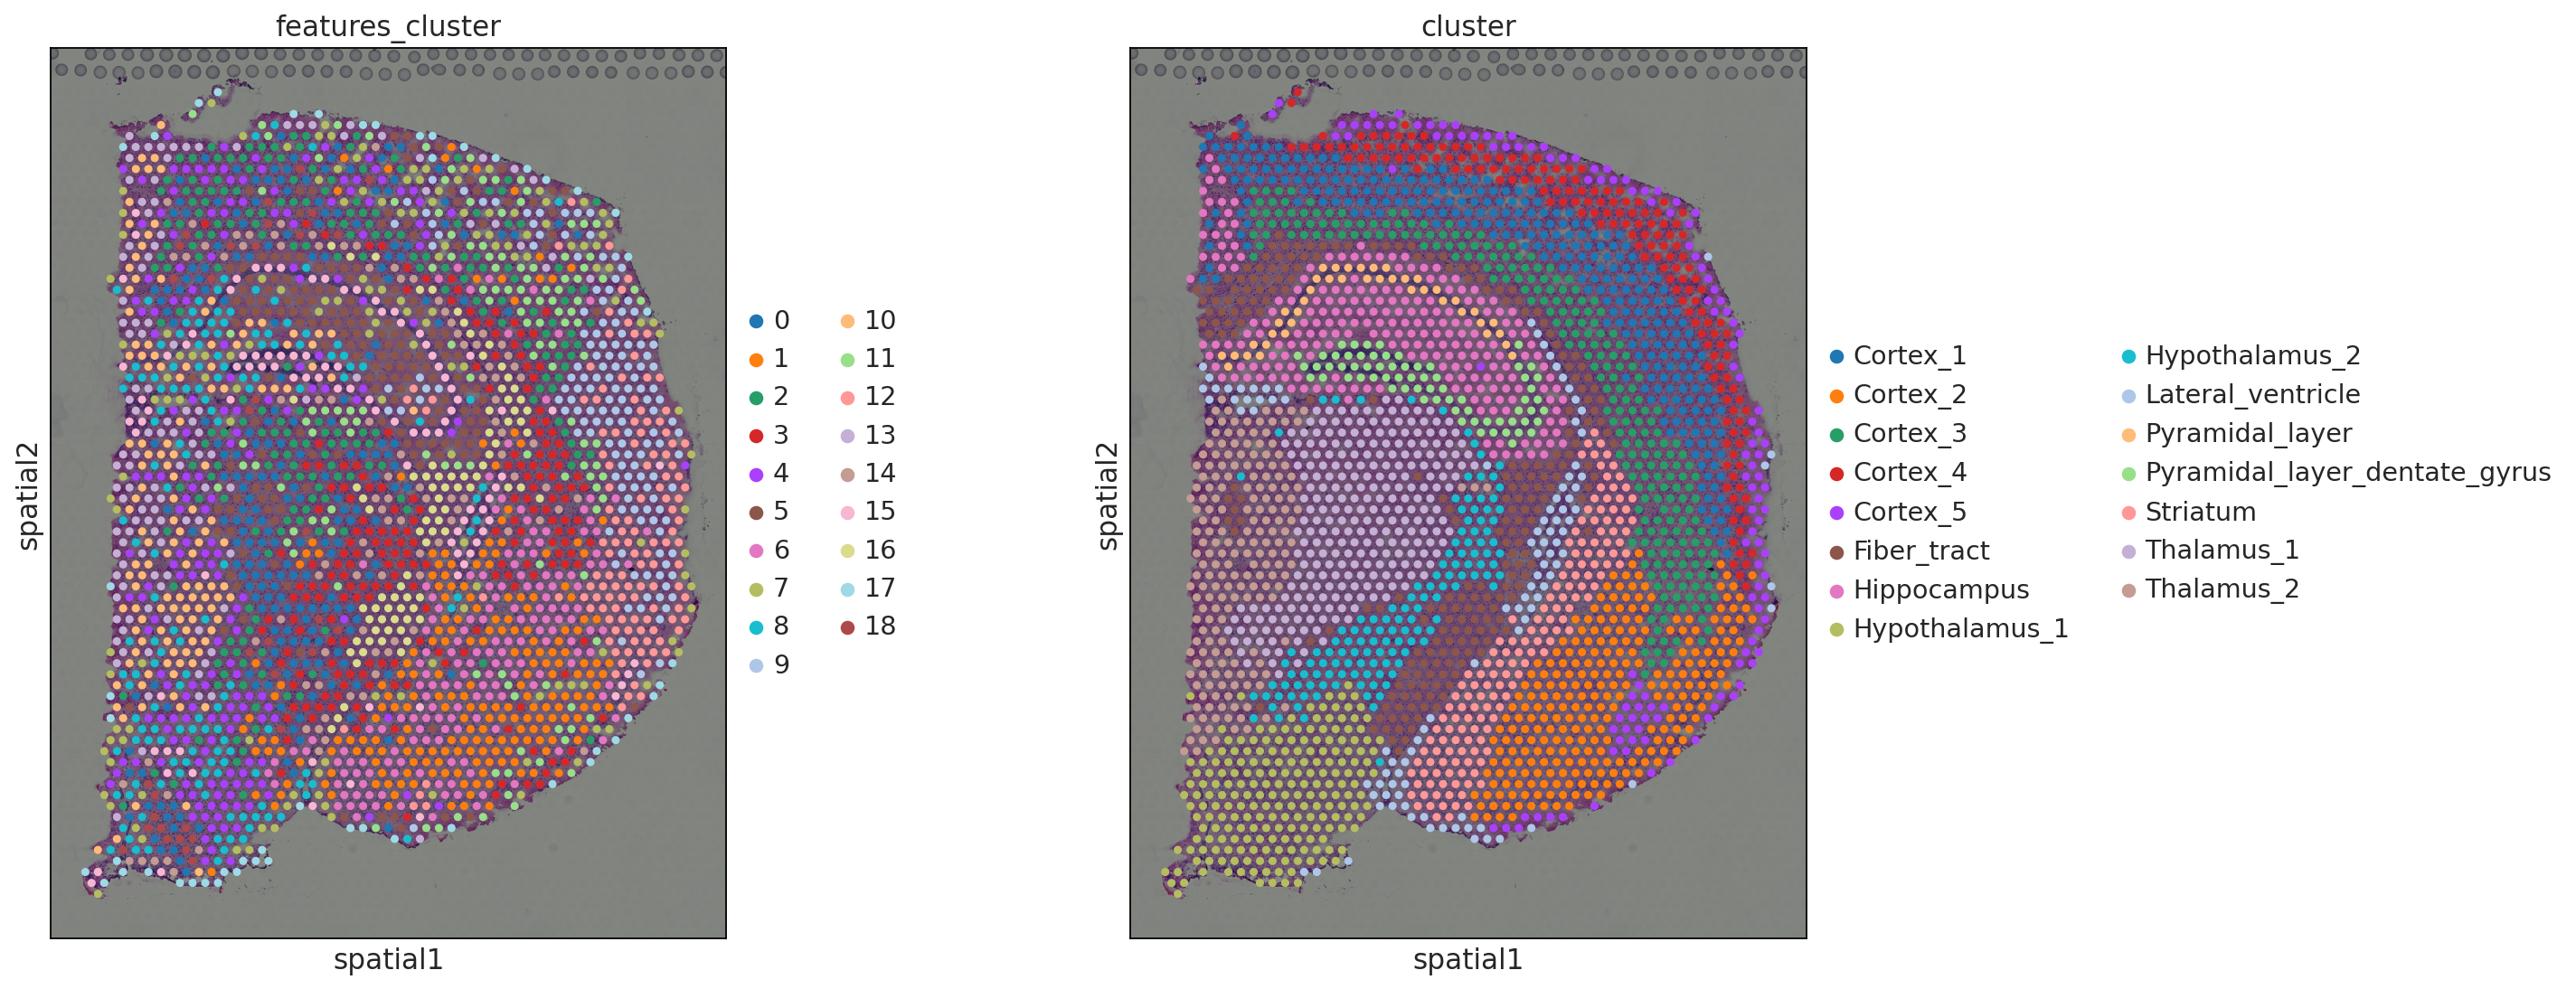

In [6]:
# helper function returning a clustering
def cluster_features(features: pd.DataFrame, like=None) -> pd.Series:
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"]


# calculate feature clusters
adata.obs["features_cluster"] = cluster_features(adata.obsm["features"], like="summary")

# compare feature and gene clusters
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.pl.spatial(adata, color=["features_cluster", "cluster"])

## Extract locations.txt and dge.txt from the anndata object

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [24]:
coord = adata.obsm['spatial']

In [26]:
# pd.DataFrame(data=coord, columns=['xcoord','ycoord']).to_csv('data/10x_MouseBrain_coordinates.csv', index=False)

In [10]:
# adata.T.to_df().to_csv('data/10x_MouseBrain_dge.csv') # that's the whole sc data that we need for reconstruction

In [11]:
# ToDo for getting the marker genes ~100 - get highly-variable genes and take the top 100 or smth

In [12]:
# highly_var_genes = []
# for i, gene in enumerate(selected_genes):
#     if gene in dataset.var_names:
#         highly_var_genes.append(np.asarray(dataset[:, gene].X).reshape(-1, 1))
# used_matrix = np.concatenate(highly_var_genes, axis=1)

In [13]:
adata.var

,gene_ids,feature_types,genome,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm,dispersions,dispersions_norm
Xkr4,ENSMUSG00000051951,Gene Expression,mm10,False,233,0.060710,0.058938,91.331845,163.187241,5.101007,233,False,NaN,0.061398,0.098832,0.815019,-0.187584,0.450155
Sox17,ENSMUSG00000025902,Gene Expression,mm10,False,298,0.080800,0.077701,88.913690,217.189590,5.385365,298,True,NaN,0.081072,0.156108,0.931378,-0.126012,0.791274
Mrpl15,ENSMUSG00000033845,Gene Expression,mm10,False,1775,0.640223,0.494832,33.965774,1720.918701,7.451194,1775,False,NaN,0.499092,2.163193,0.850736,-0.725734,-0.780380
Lypla1,ENSMUSG00000025903,Gene Expression,mm10,False,1293,0.392220,0.330900,51.897321,1054.287109,6.961568,1293,False,NaN,0.334688,0.984143,0.873699,-0.517405,-0.056071
Tcea1,ENSMUSG00000033813,Gene Expression,mm10,False,1974,0.767533,0.569585,26.562500,2063.127686,7.632463,1974,False,NaN,0.575982,3.030447,0.856292,-0.807106,-0.415730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tmlhe,ENSMUSG00000079834,Gene Expression,mm10,False,72,0.015380,0.015263,97.321429,41.342403,3.745789,72,False,NaN,0.015051,0.029366,0.888284,-0.430993,-0.898377
Gm10931,ENSMUSG00000094350,Gene Expression,mm10,False,5,0.001563,0.001561,99.813988,4.200069,1.648672,5,False,NaN,0.001727,0.001857,0.984078,0.057558,1.808282
AC149090.1,ENSMUSG00000095041,Gene Expression,mm10,False,2318,1.169316,0.774412,13.764881,3143.119385,8.053289,2318,False,3150.0,0.781621,10.516454,1.096961,-1.074191,-0.018305
CAAA01118383.1,ENSMUSG00000063897,Gene Expression,mm10,False,694,0.181425,0.166721,74.181548,487.670959,6.191689,694,False,NaN,0.169695,0.370647,0.850570,-0.365203,-0.375932


In [7]:
gene = 'Sox17'
adata.var['highly_variable'][gene]

True

In [5]:
adata.var[['highly_variable','mt','n_cells_by_counts','mean_counts','variances_norm','dispersions_norm']]

,highly_variable,mt,n_cells_by_counts,mean_counts,variances_norm,dispersions_norm
Xkr4,False,False,233,0.060710,0.815019,0.450155
Sox17,True,False,298,0.080800,0.931378,0.791274
Mrpl15,False,False,1775,0.640223,0.850736,-0.780380
Lypla1,False,False,1293,0.392220,0.873699,-0.056071
Tcea1,False,False,1974,0.767533,0.856292,-0.415730
...,...,...,...,...,...,...
Tmlhe,False,False,72,0.015380,0.888284,-0.898377
Gm10931,False,False,5,0.001563,0.984078,1.808282
AC149090.1,False,False,2318,1.169316,1.096961,-0.018305
CAAA01118383.1,False,False,694,0.181425,0.850570,-0.375932


In [6]:
%%time

# get a list of all the column names
high_var_index = adata.var[adata.var['highly_variable'] == True].index
highly_var_genes = []

for gene in high_var_index[:100]: # 100 consumes around 10GB of RAM
    highly_var_genes.append(np.asarray(adata[:, gene].X).reshape(-1, 1))
used_matrix = np.concatenate(highly_var_genes, axis=1)

CPU times: user 2.59 s, sys: 1.07 s, total: 3.66 s
Wall time: 3.65 s


In [17]:
type(highly_var_genes)

list

In [8]:
high_var_index.size

3155

In [31]:
%%time
# get a list of all the column names
high_var_index = adata.var[adata.var['highly_variable'] == True].index
# highly_var_genes = []
highly_var_genes = {}
for gene in high_var_index[:100]: # 26,6 -> 39 = 12GB
    highly_var_genes[gene] = np.asarray(adata[:, gene].X).reshape(-1,1)
print(highly_var_genes)

{'Sox17': array([[<2688x1 sparse matrix of type '<class 'numpy.float32'>'
        	with 298 stored elements in Compressed Sparse Row format>]],
      dtype=object), '4732440D04Rik': array([[<2688x1 sparse matrix of type '<class 'numpy.float32'>'
        	with 61 stored elements in Compressed Sparse Row format>]],
      dtype=object), 'St18': array([[<2688x1 sparse matrix of type '<class 'numpy.float32'>'
        	with 414 stored elements in Compressed Sparse Row format>]],
      dtype=object), 'Adhfe1': array([[<2688x1 sparse matrix of type '<class 'numpy.float32'>'
        	with 832 stored elements in Compressed Sparse Row format>]],
      dtype=object), '3110035E14Rik': array([[<2688x1 sparse matrix of type '<class 'numpy.float32'>'
        	with 1814 stored elements in Compressed Sparse Row format>]],
      dtype=object), 'Sgk3': array([[<2688x1 sparse matrix of type '<class 'numpy.float32'>'
        	with 553 stored elements in Compressed Sparse Row format>]],
      dtype=object), 

In [20]:
high_var_index = adata.var[adata.var['highly_variable'] == True].index
for gene in high_var_index[:100]: # 26,6 -> 39 = 12GB
    highly_var_genes[gene] = np.asarray(adata[:, gene].X).reshape(-1,1)
print(highly_var_genes)

<2688x1 sparse matrix of type '<class 'numpy.float32'>'
	with 199 stored elements in Compressed Sparse Row format>

Try a naive csv file writing column wise

In [47]:
# with open("data/tmp.txt",'a', newline='') as file:
#     for gene in high_var_index[:2]:
#         gene_data = pd.DataFrame(adata[:, gene].X)
#         np.savetxt(file, gene_data, delimiter=', ', fmt='%s')
#         file.write("\t")

In [9]:
high_var_index = adata.var[adata.var['highly_variable'] == True].index
print(high_var_index[:2])

Index(['Sox17', '4732440D04Rik'], dtype='object')


In [87]:
adata

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [95]:
type(adata.X[:, 4:10].toarray())

numpy.ndarray

In [97]:
high_var_index[:2]

Index(['Sox17', '4732440D04Rik'], dtype='object')

In [111]:
adata.var_names.get_loc('4732440D04Rik')

10

In [113]:
atlas_genes_indexes = []
for gene in high_var_index[:10]:
    atlas_genes_indexes.append(adata.var_names.get_loc(gene))
atlas_genes_indexes

[1, 10, 11, 16, 17, 21, 30, 32, 38, 44]

In [119]:
data_to_write = pd.DataFrame(adata.X[:,atlas_genes_indexes].toarray(),columns=high_var_index[:10])
data_to_write.to_csv("data/tmp.txt", index_label=False)

In [102]:
adata[:,gene].X

<2688x1 sparse matrix of type '<class 'numpy.float32'>'
	with 298 stored elements in Compressed Sparse Row format>

# Check randomnes/uniqueness of the marker gene locations

In order to have a good atlas, the marker genes should not all be cluttered in one or few locations but should actually span the whole map - ideally.

There are two ideas so far:

* Nikos: sth simple like counting gene combos per spot should work e.g. spot1:gene1_gene3_gene4, spot2:gene1_gene2, spot3:gene4 etc, all three spots are unique here
Comment me: although then I still don't know how distributed the spots are, no?
* I think I would like to try some kind of randomness test on how much the points aka locaiton cooridantes are distributed accross the space - and maybe additionally how much of the space they cover. Maybe getting some kind of ratio value from this and using this as orientation
* Some reading on the randomness stuff is [here](https://www.geeksforgeeks.org/runs-test-of-randomness-in-python/#:~:text=Runs%20test%20of%20randomness%20is,increasing%20values%20or%20decreasing%20values.)
* also wikipedia, also ask Jakob :)